## Domača naloga 7
Marko Tacer, 23222087

Podatki: \
Kvantizacija \
frekvenca: 5 Hz \
Dolžina segmenta: 3 $s$ \
Ramp

In [401]:
import lvm_read
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
#import pyEMA;
%matplotlib inline
X = 5/1024

In [402]:
5/(2**10)

0.0048828125

### Kvantizacija


Za primer kvantizacije sem najprej ugotavljal, kakšen je razpon med razredi oz nivoji našega zaznavala. Ker je 10-bitno to pomeni, da je merilno območje razdeljeno na $2^{10}$ območij. Pri 5V merilnem območju (0-5)V to pomeni, da je med dvema nivojema $\approx 0.00488V$. Ker sem želel, da bi moj signal šel skozi 5 nivojev sem amplitudo nastavil na $5 \cdot \Delta V$ (peak to peak) torej 2.5 $\Delta V$. Žal se je pojavilo veliko šuma oz nekakšna napaka meritve, zato izmerjen signal ni najboljši. Offset je bil nastavljen na 1.92VDC.

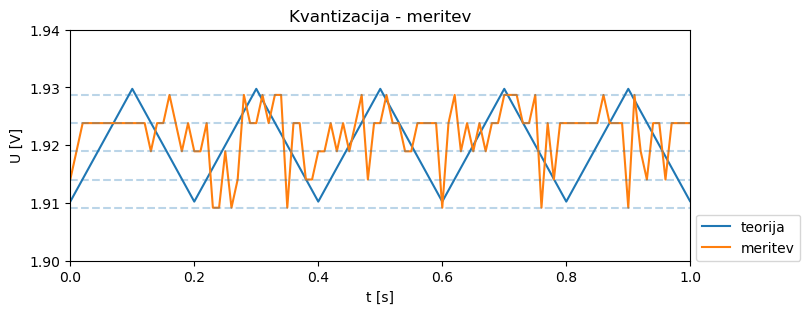

In [409]:
file = f'S1.lvm'
loaded_data = lvm_read.read(file)
loaded_data[0]['data'].shape[0]
# Ker smo meritve posneli kar eno za drugo jih najprej razdelim na segmente
S = loaded_data[0]['data'].T 
t = S[0]
S1 = S[1]
S2 = S[2]
# Vidim, da je segmentov 8 (po 400 vzorcev), zato pripravim prazne arraye 
Ti = np.array([[0.00 for i in np.arange(400)] for j in np.arange(8)])
S11 = np.array([[0.00 for i in np.arange(400)] for j in np.arange(8)])
S22 = np.array([[0.00 for i in np.arange(400)] for j in np.arange(8)])

# Preberem in napolnim arraye
for i in np.arange(8):
    ti = t[400*i:400*(i+1)]
    s1 = S1[400*i:400*(i+1)]
    s2 = S2[400*i:400*(i+1)]
    
    Ti[i] = ti
    S11[i] = s1
    S22[i] = s2

# Izberem meritev 3
k = 3
t = Ti[k]
s1 = S11[k]
s2 = S22[k]


teorija = 2*X*(signal.sawtooth(2 * np.pi * 5  * t , width=0.5)) + 1.92 # Če želimo da je peak to peak 5 razdredov je spredaj faktor 2.5
# teorija = 2*X*np.sin(2 * np.pi* t) + 1.92

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title("Kvantizacija - meritev")

ax.plot(t, teorija, label='teorija')
ax.plot(t, s1, label=f'meritev')
for i in np.arange(5):
    ax.hlines((391+i)*X, 0, 4 ,linestyles='dashed', alpha=0.3)
ax.set_xlim(0, 1)
ax.set_xlabel("t [s]")
ax.set_ylabel("U [V]")
ax.set_ylim(1.90, 1.94)
ax.legend(loc=(1.01, 0));

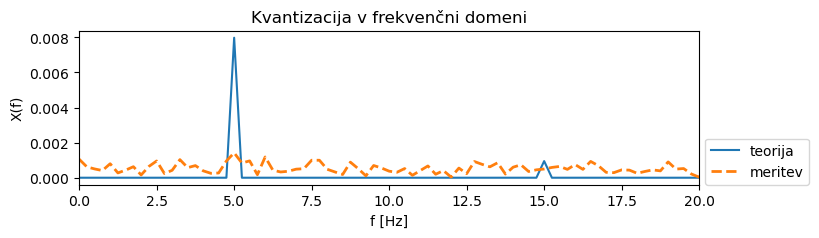

In [412]:
OFF = 1.92
freq = np.fft.rfftfreq(len(t), d=dt)
S1 = np.fft.rfft(s1 - OFF)/len(t);
S1[1:] *= 2
X_teorija = np.fft.rfft(teorija - OFF)/len(t);
X_teorija[1:] *= 2

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_title("Kvantizacija v frekvenčni domeni")
ax.plot(freq, abs(X_teorija), label='teorija')
ax.plot(freq, abs(S1), '--', lw=2, label='meritev')
ax.set_xlabel('f [Hz]')
ax.set_xlim(0, 20)
ax.set_ylabel('X(f)')
ax.legend(loc=(1.01, 0));

In [413]:
# t = np.linspace(0, 10, 1001)
# dt = t[2]-t[1]
# f = 3
# y = np.sin(2*np.pi * f * t)
# plt.plot(t, y)x
# freq = np.fft.rfftfreq(len(t), dt)
# S_r = np.fft.rfft(y) / len(t)
# S_r[1:] *= 2
# plt.plot(freq, S_r)
# plt.xlim(0, 5)

Ker meritev slabo prikaže samo težavo kvantifikacije podatkov bom to prikazal s pomočjo funkcije s predavanj. 

In [414]:
def get_quantized(x, bits = 4, adc_range = (-2, 2)):
    x2 = x.copy()
    lo, hi = adc_range
    x2[x<=lo] = lo
    x2[x>=hi] = hi
    delta = (hi - lo) / (2**(bits)-1)
    qnt = lo+delta*np.floor((x2-lo)/delta) + delta/2
    return qnt

Signal sicer traja 4s a zaradi boljše preglednsti prikažem le 1s.

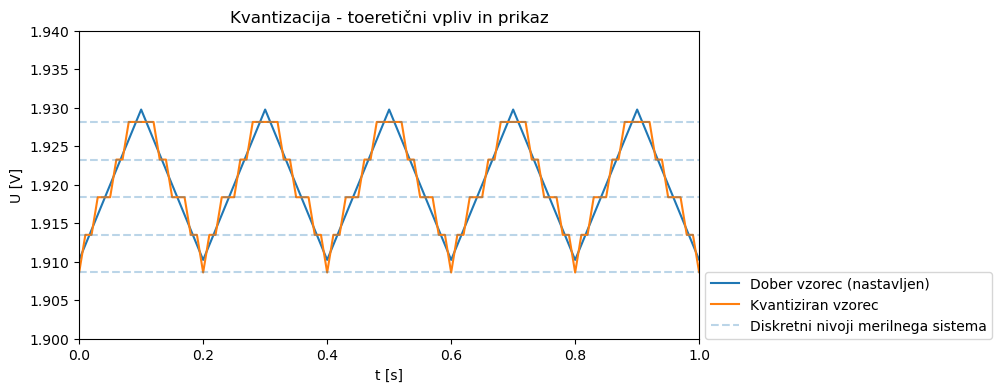

In [415]:
bit = 10            # Dejanske lastnosti Arduino
range = (0, 5)      # Območje Arduina
kvant = get_quantized(teorija, bits = bit, adc_range=range)

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Kvantizacija - toeretični vpliv in prikaz")

ax.plot(t, teorija, label='Dober vzorec (nastavljen)')
ax.plot(t, kvant, label=f'Kvantiziran vzorec')
for i in np.arange(5):
    ax.hlines(min(kvant)+i*X, 0, 4 , linestyles='dashed', alpha=0.3, label='Diskretni nivoji merilnega sistema' if i == 0 else "")
ax.set_xlim(0, 1)
ax.set_xlabel("t [s]")
ax.set_ylabel("U [V]")
ax.set_ylim(1.90, 1.94)
ax.legend(loc=(1.01, 0));

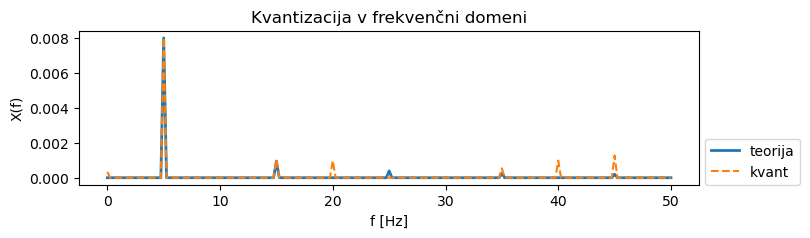

In [418]:
OFF = 1.92
freq = np.fft.rfftfreq(len(t), dt)

X_kvant = np.fft.rfft(kvant - OFF)/len(t);
X_kvant[1:] *= 2
X_teorija = np.fft.rfft(teorija - OFF)/len(t);
X_teorija[1:] *= 2

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_title("Kvantizacija v frekvenčni domeni")
ax.plot(freq, abs(X_teorija), lw=2 , label='teorija')
ax.plot(freq, abs(X_kvant), '--', label='kvant')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('X(f)')
ax.legend(loc=(1.01, 0));

### Podvzorčenje

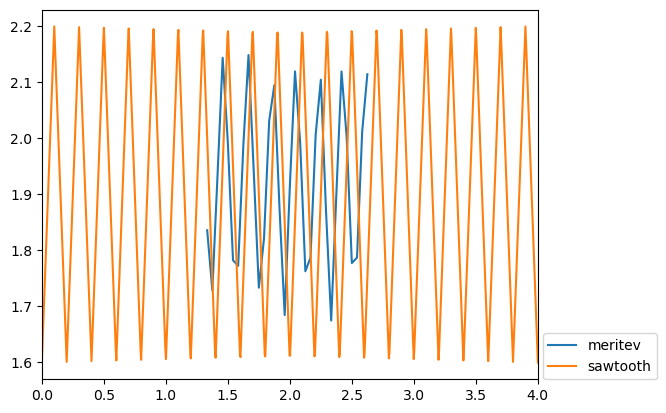

In [ ]:
file = f'S3.lvm'
loaded_data = lvm_read.read(file)
loaded_data[0]['data'].shape[0]
S = loaded_data[0]['data'].T
t = S[0]
S1 = S[1]
S2 = S[2]

h = 32
k = int(t.size/h)
Ti = np.array([[0.00 for i in range(h)] for j in range(k)])
S11 = np.array([[0.00 for i in range(h)] for j in range(k)])
S22 = np.array([[0.00 for i in range(h)] for j in range(k)])



for i in np.arange(k):
    ti = t[h*i:h*(i+1)]
    s1 = S1[h*i:h*(i+1)]
    s2 = S2[h*i:h*(i+1)]
    
    Ti[i] = ti
    S11[i] = s1
    S22[i] = s2
t = Ti[3]
dt = t[1] - t[0]
X = 0.30
F = 4
tt = np.linspace(0, 4, 1000)
plt.plot(Ti[F], S11[F],  label='meritev')
plt.plot(tt, X*(signal.sawtooth(2 * np.pi * 5 * tt, width=0.5)) + 1.9, label='sawtooth')
plt.xlim(0, 4)
plt.legend(loc=(1.01, 0))
plt.show()  

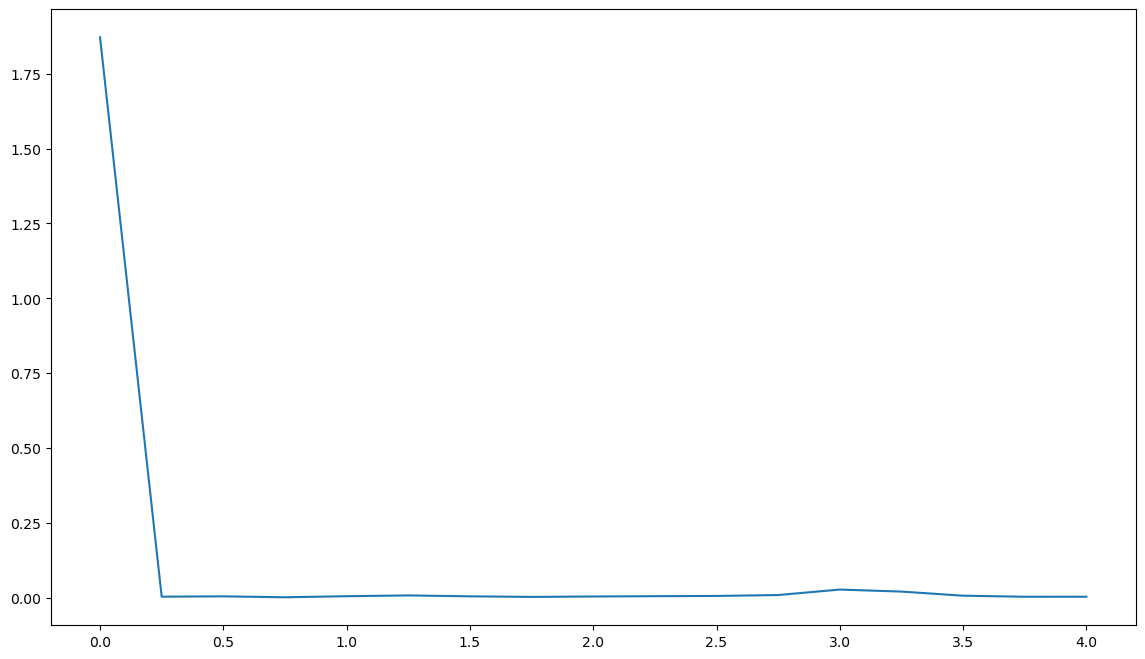

In [ ]:
freq = np.fft.rfftfreq(len(t), dt)
X_1 = np.fft.rfft(S11[3], norm="forward");
X_2 = np.fft.rfft(S22[3], norm="forward");

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(freq, abs(X_2))